In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean
from glob import glob
import sys
import gsw as gsw
import copy as copy
import matplotlib as mpl
def modtime(H):
    try:
        datetimeindex = H.indexes['Time'].to_datetimeindex()
        H['Time']=datetimeindex
    except:
        datetimeindex = H.indexes['time'].to_datetimeindex()
        H['time']=datetimeindex
        
    return H

In [2]:
#This should point to where LES and SCM model data are located
data_loc = '/net/bgr/Work/Tropics_Paper/Paper/Data'

LES0 = xr.open_dataset(data_loc+'/ROMS_PSH_6HRLIN_0N140W_360x360x216_22OCT2020.nc').isel(z=slice(0,215))
LES3 = xr.open_dataset(data_loc+'/ROMS_PSH_6HRLIN_3N140W_360x360x216_22OCT2020.nc').isel(z=slice(0,215))

LES0_1h = LES0.resample(time='1H').interpolate(kind="linear")
LES3_1h = LES3.resample(time='1H').interpolate(kind="linear")

rho0=LES0.rho0.values
alpha = LES0.alpha.values
beta = LES0.beta.values

for LES in [LES0,LES3]:

    # w'b' = w'T' * g alpha
    # m2/s3 = m/s * K * m * 1/s2 * 1/K

    LES['dVdt']=(LES.vme.differentiate(coord='time',datetime_unit='s')).T
    LES['dUdt']=(LES.ume.differentiate(coord='time',datetime_unit='s')).T
    LES['dSdt']=(LES.saltme.differentiate(coord='time',datetime_unit='s')).T
    LES['dTdt']=(LES.tempme.differentiate(coord='time',datetime_unit='s')).T
    LES['Kd_T'] = ((-LES.tempw+LES.kappadtdz)/LES.tempme.differentiate(coord='z')).T
    LES['Kd_S'] = ((-LES.saltw+LES.kappadsdz)/LES.saltme.differentiate(coord='z')).T
    LES['Kv_U'] = ((-LES.uw+LES.nududz)/LES.ume.differentiate(coord='z')).T
    LES['Kv_V'] = ((-LES.vw+LES.nudvdz)/LES.vme.differentiate(coord='z')).T
    LES['Pv'] = ((-LES.vw+LES.nudvdz)*LES.vme.differentiate(coord='z')).T
    LES['Pu'] = ((-LES.uw+LES.nududz)*LES.ume.differentiate(coord='z')).T
    LES['Gt'] = -((-LES.tempw+LES.kappadtdz)*alpha*9.81).T
    LES['Gs'] = -((-LES.saltw+LES.kappadsdz)*beta*9.81).T
    LES['tke'] = 0.5*(LES.urms**2+LES.vrms**2+LES.wrms**2).T
    LES['Ri']=LES.N2/LES.S2
    
for LES1h in [LES0_1h,LES3_1h]:
    LES1h['vmeFORCE']=(LES1h.vme.isel(time=0)+LES1h.dVdtFORCE.cumsum(dim='time')*3600.).T
    LES1h['dVdt']=(LES1h.vme.differentiate(coord='time',datetime_unit='s')).T
    LES1h['dUdt']=(LES1h.ume.differentiate(coord='time',datetime_unit='s')).T
    LES1h['dSdt']=(LES1h.saltme.differentiate(coord='time',datetime_unit='s')).T
    LES1h['dTdt']=(LES1h.tempme.differentiate(coord='time',datetime_unit='s')).T
    LES1h['Kd_T'] = ((-LES1h.tempw+LES1h.kappadtdz)/LES1h.tempme.differentiate(coord='z')).T
    LES1h['Kd_S'] = ((-LES1h.saltw+LES1h.kappadsdz)/LES1h.saltme.differentiate(coord='z')).T
    LES1h['Kv_U'] = ((-LES1h.uw+LES1h.nududz)/LES1h.ume.differentiate(coord='z')).T
    LES1h['Kv_V'] = ((-LES1h.vw+LES1h.nudvdz)/LES1h.vme.differentiate(coord='z')).T
    LES1h['Pv'] = ((-LES1h.vw+LES1h.nudvdz)*LES1h.vme.differentiate(coord='z')).T
    LES1h['Pu'] = ((-LES1h.uw+LES1h.nududz)*LES1h.ume.differentiate(coord='z')).T
    LES1h['Gt'] = -((-LES1h.tempw+LES1h.kappadtdz)*alpha*9.81).T
    LES1h['Gs'] = -((-LES1h.saltw+LES1h.kappadsdz)*beta*9.81).T
    LES1h['tke'] = 0.5*(LES1h.urms**2+LES1h.vrms**2+LES1h.wrms**2).T
    LES1h['Ri']=LES1h.N2/LES1h.S2

/net2/bgr/anaconda3/envs/oceans/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/net2/bgr/anaconda3/envs/oceans/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/net2/bgr/anaconda3/envs/oceans/lib/python3.8/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/net2/bgr/anaconda3/envs/oceans/lib/python3.8/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to 

In [3]:
MOM0 = modtime(xr.open_dataset(data_loc+'/19851002.ocean_hourly_ePBL_RH18_0.nc').isel(xh=0,yh=0,xq=0).squeeze())
MOM3 = modtime(xr.open_dataset(data_loc+'/19851002.ocean_hourly_ePBL_RH18_3.nc').isel(xh=0,yh=0,xq=0).squeeze())

/tmp/ipykernel_3730731/2925081973.py:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = H.indexes['time'].to_datetimeindex()
/tmp/ipykernel_3730731/2925081973.py:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = H.indexes['time'].to_datetimeindex()


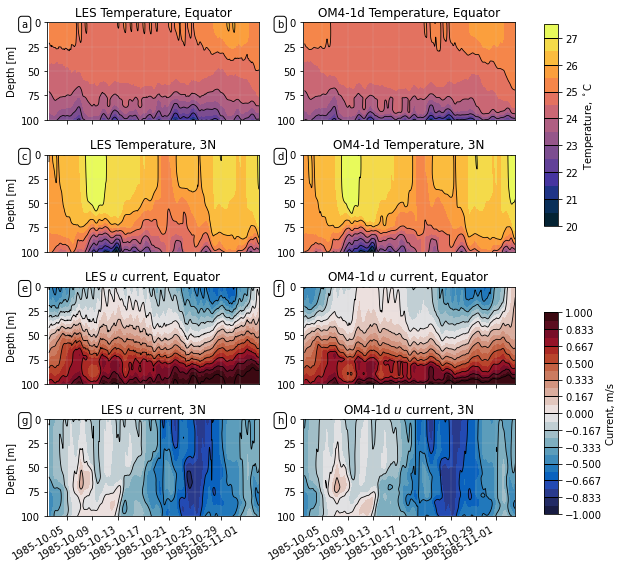

In [4]:
# Compare Temperatures

cmap=cmocean.cm.thermal
levels_T=np.linspace(20,27.5,16)

f,a = plt.subplots(4,2,figsize=(8,8))

ax=a.ravel()[0]
C=ax.pcolormesh(LES0_1h.time.values,-1*LES0_1h.z,LES0_1h.tempme.values.T,
                  cmap=cmap,
                  norm = mpl.colors.BoundaryNorm(levels_T, ncolors=cmap.N, clip=False)
                 )
ax.contour(LES0_1h.time.values,-1*LES0_1h.z,LES0_1h.tempme.values.T,
           levels=levels_T[::2],
           colors=['k',],
           linestyles=['-'],
           linewidths=[0.8,],                   
          )
ax.grid(True, color='lightgray', linestyle=':', linewidth=0.4)
ax.set_xlim('1985/10/02','1985/11/04')
ax.set_ylim(100,0)
ax.set_title('LES Temperature, Equator')
ax.set_ylabel('Depth [m]')

ax=a.ravel()[1]
C=ax.pcolormesh(MOM0.time.values,MOM0.zl.values,MOM0.thetao.values.T,
                  cmap=cmap,
                  norm = mpl.colors.BoundaryNorm(levels_T, ncolors=cmap.N, clip=False)
                  )
ax.contour(MOM0.time.values,MOM0.zl.values,MOM0.thetao.values.T,
           levels=levels_T[::2],
           colors=['k',],
           linestyles=['-'],
           linewidths=[0.8,],                   
          )
ax.grid(True, color='lightgray', linestyle=':', linewidth=0.4)
ax.set_xlim('1985/10/02','1985/11/04')
ax.set_ylim(100,0)
ax.set_title('OM4-1d Temperature, Equator')

ax=a.ravel()[2]
C=ax.pcolormesh(LES3_1h.time.values,-1*LES3_1h.z,LES3_1h.tempme.values.T,
                  cmap=cmap,
                  norm = mpl.colors.BoundaryNorm(levels_T, ncolors=cmap.N, clip=False)
                 )
ax.contour(LES3_1h.time.values,-1*LES3_1h.z,LES3_1h.tempme.values.T,
           levels=levels_T[::2],
           colors=['k',],
           linestyles=['-'],
           linewidths=[0.8,],                   
          )
ax.grid(True, color='lightgray', linestyle=':', linewidth=0.4)
ax.set_xlim('1985/10/02','1985/11/04')
ax.set_ylim(100,0)
ax.set_title('LES Temperature, 3N')
ax.set_ylabel('Depth [m]')

ax=a.ravel()[3]
C=ax.pcolormesh(MOM3.time.values,MOM3.zl.values,MOM3.thetao.values.T,
                  cmap=cmap,
                  norm = mpl.colors.BoundaryNorm(levels_T, ncolors=cmap.N, clip=False)
                  )
ax.contour(MOM3.time.values,MOM3.zl.values,MOM3.thetao.values.T,
           levels=levels_T[::2],
           colors=['k',],
           linestyles=['-'],
           linewidths=[0.8,],                   
          )
ax.grid(True, color='lightgray', linestyle=':', linewidth=0.4)
ax.set_xlim('1985/10/02','1985/11/04')
ax.set_ylim(100,0)
ax.set_title('OM4-1d Temperature, 3N')


    
    
# Compare U current

cmap=cmocean.cm.balance
levels_S=np.linspace(-1,1,25)


ax=a.ravel()[4]
C2=ax.pcolormesh(LES0_1h.time.values,-1*LES0_1h.z,LES0_1h.ume.values.T,
                  cmap=cmap,
                  norm = mpl.colors.BoundaryNorm(levels_S, ncolors=cmap.N, clip=False)
                 )
ax.contour(LES0_1h.time.values,-1*LES0_1h.z,LES0_1h.ume.values.T,
           levels=levels_S[::2],
           colors=['k',],
           linestyles=['-'],
           linewidths=[0.8,],                   
          )
ax.grid(True, color='lightgray', linestyle=':', linewidth=0.4)
ax.set_xlim('1985/10/02','1985/11/04')
ax.set_ylim(100,0)
ax.set_title('LES $u$ current, Equator')
ax.set_ylabel('Depth [m]')

ax=a.ravel()[5]
C2=ax.pcolormesh(MOM0.time.values,MOM0.zl.values,MOM0.uo.values.T,
                  cmap=cmap,
                  norm = mpl.colors.BoundaryNorm(levels_S, ncolors=cmap.N, clip=False)
                  )
ax.contour(MOM0.time.values,MOM0.zl.values,MOM0.uo.values.T,
           levels=levels_S[::2],
           colors=['k',],
           linestyles=['-'],
           linewidths=[0.8,],                   
          )
ax.grid(True, color='lightgray', linestyle=':', linewidth=0.4)
ax.set_xlim('1985/10/02','1985/11/04')
ax.set_ylim(100,0)
ax.set_title('OM4-1d $u$ current, Equator')

ax=a.ravel()[6]
C2=ax.pcolormesh(LES3_1h.time.values,-1*LES3_1h.z,LES3_1h.ume.values.T,
                  cmap=cmap,
                  norm = mpl.colors.BoundaryNorm(levels_S, ncolors=cmap.N, clip=False)
                 )
ax.contour(LES3_1h.time.values,-1*LES3_1h.z,LES3_1h.ume.values.T,
           levels=levels_S[::2],
           colors=['k',],
           linestyles=['-'],
           linewidths=[0.8,],                   
          )
ax.grid(True, color='lightgray', linestyle=':', linewidth=0.4)
ax.set_xlim('1985/10/02','1985/11/04')
ax.set_ylim(100,0)
ax.set_title('LES $u$ current, 3N')
ax.set_ylabel('Depth [m]')

ax=a.ravel()[7]
C2=ax.pcolormesh(MOM3.time.values,MOM3.zl.values,MOM3.uo.values.T,
                  cmap=cmap,
                  norm = mpl.colors.BoundaryNorm(levels_S, ncolors=cmap.N, clip=False)
                  )
ax.contour(MOM3.time.values,MOM3.zl.values,MOM3.uo.values.T,
           levels=levels_S[::2],
           colors=['k',],
           linestyles=['-'],
           linewidths=[0.8,],                   
          )
ax.grid(True, color='lightgray', linestyle=':', linewidth=0.4)
ax.set_xlim('1985/10/02','1985/11/04')
ax.set_ylim(100,0)
ax.set_title('OM4-1d $u$ current, 3N')


f.autofmt_xdate()
f.tight_layout()

f.subplots_adjust(right=0.9)

cbar_ax = f.add_axes([0.95, 0.6, 0.025, 0.35])
cb=f.colorbar(C, cax=cbar_ax)
cb.set_label('Temperature, $^\circ$C')
cb.set_ticks(levels_T[::2])
for level in levels_T[::2]:
    cb.ax.axhline(y=level, color='k', linewidth=1)

cbar_ax = f.add_axes([0.95, 0.1, 0.025, 0.35])
cb=f.colorbar(C2, cax=cbar_ax)
cb.set_label('Current, m/s')
cb.set_ticks(levels_S[::2])
for level in levels_S[::2]:
    cb.ax.axhline(y=level, color='k', linewidth=1)
    
for AXi in range(8):
    txt='abcdefghijklmnopqrstuvwyxz'[AXi]
    a.ravel()[AXi].text('1985/9/28',5,txt,bbox=dict(boxstyle='round', facecolor='white'))

f.savefig('../Fig/LES-MOM1d-TandU.png',dpi=200,bbox_inches = "tight")

